In [178]:
import numpy as np
import skimage as ski
from scipy.ndimage import gaussian_filter
from skimage import io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray, rgba2rgb
%matplotlib inline

# **Canny Edge Detector**

In [155]:
def canny_edge_detection(image, sigma=2.0, low_threshold=50, high_threshold=150):
    # Convert the image to grayscale
    gray_image = rgb2gray(image)  # modified
    
    # Apply Gaussian smoothing to reduce noise
    smoothed_image = ski.filters.gaussian(gray_image,sigma)
    
    # Compute gradients using Sobel filters
    gradient_x = np.gradient(smoothed_image, axis=1)
    gradient_y = np.gradient(smoothed_image, axis=0)

    # Compute gradient magnitude and direction
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_direction = np.arctan2(gradient_y, gradient_x)
    
    # Apply non-maximum suppression to thin the edges
    suppressed_image = np.zeros_like(gradient_magnitude)

    for i in range(1, gradient_magnitude.shape[0] - 1):
        for j in range(1, gradient_magnitude.shape[1] - 1):
            angle = gradient_direction[i, j]
            if (0 <= angle < np.pi/8) or (7*np.pi/8 <= angle <= np.pi):
                q = gradient_magnitude[i, j+1]
                r = gradient_magnitude[i, j-1]
            elif (np.pi/8 <= angle < 3*np.pi/8):
                q = gradient_magnitude[i+1, j-1]
                r = gradient_magnitude[i-1, j+1]
            elif (3*np.pi/8 <= angle < 5*np.pi/8):
                q = gradient_magnitude[i+1, j]
                r = gradient_magnitude[i-1, j]
            else:
                q = gradient_magnitude[i-1, j-1]
                r = gradient_magnitude[i+1, j+1]
            if gradient_magnitude[i, j] >= q and gradient_magnitude[i, j] >= r:
                suppressed_image[i, j] = gradient_magnitude[i, j]
    
    suppressed_image = suppressed_image * 255  # modified
    
    # Apply hysteresis thresholding to detect edges
    edges = np.zeros_like(suppressed_image)
    strong_edges = suppressed_image > high_threshold
    edges[strong_edges] = 255
    
    weak_edges = (suppressed_image >= low_threshold) & (suppressed_image <= high_threshold)
    max_iter = 50 # modified
    while (np.sum(weak_edges) > 0 and max_iter > 0): # modified
        max_iter -= 1
        weak_edges_coords = np.argwhere(weak_edges)
        i, j = weak_edges_coords[0]
        edges[i, j] = 255
        weak_edges[i, j] = False
        neighbors = weak_edges[max(0, i-1):min(i+2, weak_edges.shape[0]), max(0, j-1):min(j+2, weak_edges.shape[1])]
        if np.sum(neighbors) > 0:
            weak_edges[np.where(neighbors)] = True

    return edges

## Testing

In [172]:
def plot_images_side_by_side(img1, img2, label1="Origianl Image", label2 = "Image Edges"):
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot the first image on the first subplot
    axes[0].imshow(img1, cmap='gray')
    axes[0].set_title(label1)

    # Plot the second image on the second subplot
    axes[1].imshow(img2, cmap='gray')
    axes[1].set_title(label2)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [174]:
# read image
img1 = io.imread("bird.jpeg")

In [167]:
%time img_edges = canny_edge_detection(img1, 3, 2, 5)

Wall time: 1.51 s


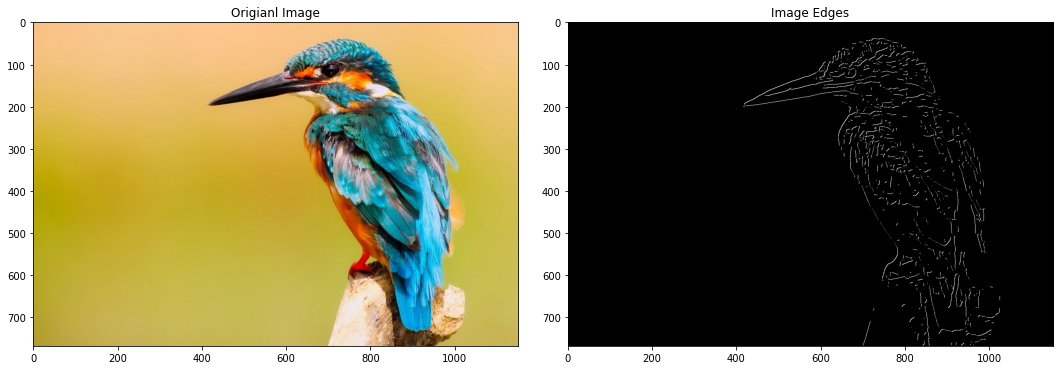

In [175]:
plot_images_side_by_side(img1, img_edges)

In [179]:
img2 = rgba2rgb(io.imread("lane.png"))

In [186]:
%time img_edges = canny_edge_detection(img2, 4, 3, 5)

Wall time: 186 ms


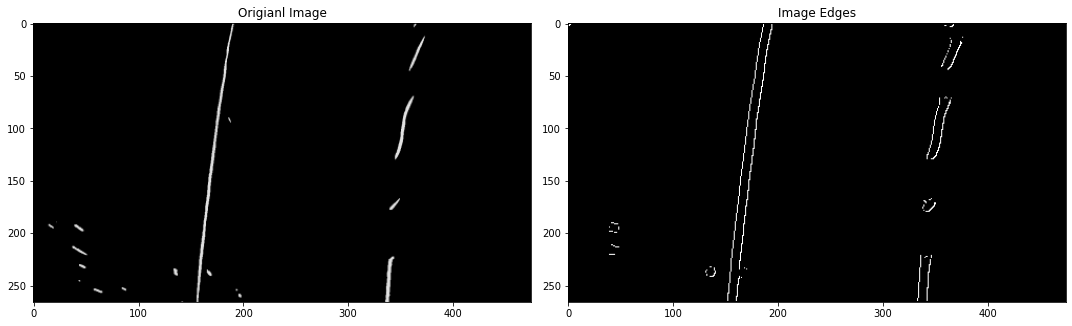

In [187]:
plot_images_side_by_side(img2, img_edges)